In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from data_utils import generate_ground_truth_matrix, ground_truth_matrix_to_dataset, to_dataframe, generate_test_dataframe
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic, SVD
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import accuracy

In [4]:
# Plot P against R (flattened)

def P_R_train(beta):
    truth = generate_ground_truth_matrix(
        (1000, 1000), environment='latent-dynamic-v1')
    users, items, ratings, P, R = ground_truth_matrix_to_dataset(
        truth, quantization='onetofive', bias='full underlying', beta=beta)
    return P, R

beta = np.linspace(0.01, 3, 6)
results = [P_R_train(i) for i in beta]     

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_81171/3830447178.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


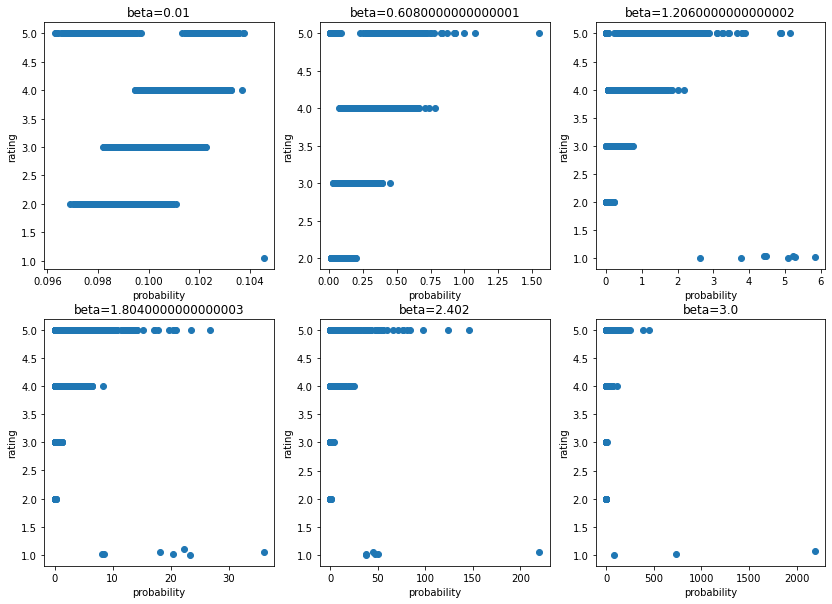

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))
for i in range(6):
    axs[i // 3, i % 3].scatter(results[i][0].flatten(), results[i][1].flatten(), linestyle='None')
    axs[i // 3, i % 3].set(xlabel='probability',
                           ylabel='rating', title=f'beta={beta[i]}')
fig.show()

In [22]:
truth = generate_ground_truth_matrix(
    (1000, 1000), environment='latent-static-v1')
users, items, ratings, P, R = ground_truth_matrix_to_dataset(
    truth, quantization='binary', bias='full underlying')
train_df = to_dataframe(ratings)

In [23]:
reader = Reader(rating_scale=(1, 2))
data = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader)
trainset = data.build_full_trainset()

knn = KNNBasic()
svd = SVD()

knn.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [25]:
test_df = generate_test_dataframe(R)
testset = Dataset.load_from_df(test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
predictions = knn.test(testset)
accuracy.rmse(predictions)

RMSE: 0.7399


0.7399496273824326

In [42]:
beta = np.linspace(0.1, 5, 50)
result = []

for i in range(len(beta)):
    truth = generate_ground_truth_matrix(
        (1000, 1000), environment='latent-static-v1')
    users, items, ratings, P, R = ground_truth_matrix_to_dataset(
        truth, quantization='onetofive', bias='full underlying', beta=beta[i])
    train_df = to_dataframe(ratings)

    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader)
    trainset = data.build_full_trainset()

    knn = KNNBasic()
    knn.fit(trainset)

    test_df = generate_test_dataframe(R)
    testset = Dataset.load_from_df(test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
    predictions = knn.test(testset)
    result.append(accuracy.rmse(predictions))

print(result)  

result5 = result

result = []

for i in range(len(beta)):
    truth = generate_ground_truth_matrix(
        (1000, 1000), environment='latent-static-v1')
    users, items, ratings, P, R = ground_truth_matrix_to_dataset(
        truth, quantization='binary', bias='full underlying', beta=beta[i])
    train_df = to_dataframe(ratings)

    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader)
    trainset = data.build_full_trainset()

    knn = KNNBasic()
    knn.fit(trainset)

    test_df = generate_test_dataframe(R)
    testset = Dataset.load_from_df(test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
    predictions = knn.test(testset)
    result.append(accuracy.rmse(predictions))

print(result)  

result2 = result

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5581
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5683
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5788
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5979
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5620
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5723
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6309
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6390
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6448
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6449
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6966
Computing the msd similarity matrix...
Done computing 

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_81171/2089485972.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


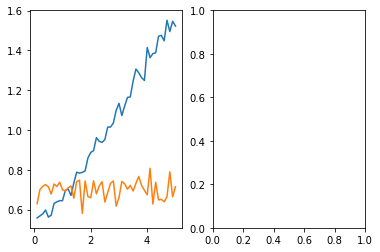

In [43]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(beta, result5)
axs[0].plot(beta, result2)
fig.show()